## Problem Set #8

MACS 30100, Dr. Evans
<br>
Due Monday, Mar. 12 at 11:30am
<br>
Liqiang Yu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

drink = pd.read_csv('./data/strongdrink.txt', sep = ',')
drink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


(a) Create a scatterplot of the data where the x-variable is alcohol (alco) and the y-variable is color intensity (color int). Make the dot of each of the three possible cultivar types a diﬀerent color. Make sure your plot has a legend.

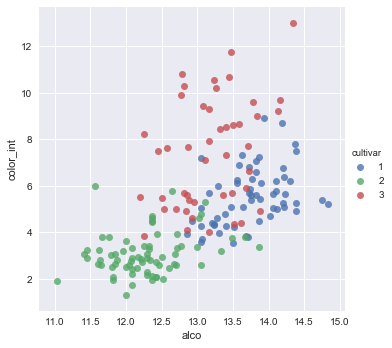

In [3]:
import seaborn as sns

sns.lmplot('alco','color_int', fit_reg=False, data=drink, hue = 'cultivar')

(b) Use sklearn.linear model.LogisticRegression to ﬁt a multinomial logistic model of cultivar on features alcohol (alco), malic acid (malic), total phenols (tot phen), and color intensity (color int) with the following linear predictor.

In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

Xvars = drink[['alco', 'malic', 'tot_phen', 'color_int']].values
yvals = drink['cultivar'].values

clf_mlog = KFold(n_splits=4, shuffle=True, random_state=22)
clf_mlog.get_n_splits(Xvars)

C = np.zeros(100)
MSE_C = np.zeros(100)

MSE_temp = np.zeros(4)

for c in range(100):
    k_ind = int(0)
    c_temp = (c + 1) / 100
    
    for train_index, test_index in clf_mlog.split(Xvars):
        X_train, X_test = Xvars[train_index], Xvars[test_index]
        y_train, y_test = yvals[train_index], yvals[test_index]
        
        # Fit Logit Regression
        LogReg = LogisticRegression(multi_class='multinomial', fit_intercept = True,
                                    solver='newton-cg', C = c_temp)
        
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        error = y_test != y_pred
        MSE_temp[k_ind] = error.mean()
        k_ind += 1

    C[c] = c_temp
    MSE_C[c] =  MSE_temp.mean()



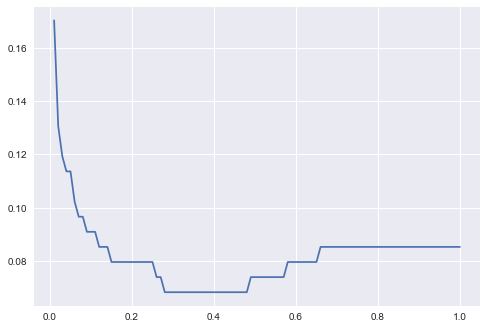

In [15]:
plt.plot(C, MSE_C)

In [21]:
MSE_logit = pd.DataFrame({'C':C, 'MSE':MSE_C})
MSE_logit.sort_values(['MSE']).head(1)

,C,MSE
36,0.37,0.068182


So when C = 0.37, the overall minimized MSE is 0.068182 with penalty 'l2'. Notice that the 'newton-cg' can only take 'l2' penalty.

(c) Use sklearn.ensemble.RandomForestClassifier to ﬁt a random forest model of cultivar on the same four features used in part (b). set bootstrap=True, set oob score=True, and set random state=22. Use OOB cross-validation to generate the MSE of your random forest classiﬁer. Play with the values of the tuning parameters n estimators, max depth, and min samples leaf to try and ﬁnd the lowest possible MSE from the OOB cross validation. Report your minimized overall MSE along with the tuning parameter values you used for n estimators, max depth, and min samples leaf.

In [24]:
from sklearn.ensemble import RandomForestClassifier

MSE_LOOP = pd.DataFrame({"min_samples_leaf" : np.zeros(5),
                         "max_depth" : np.zeros(5),
                         "n_estimator" : np.zeros(5),
                         "MSE" : np.zeros(5)})
MSE_RF = MSE_LOOP[:0]
for msl in range(5):
    for md in range(9):
        for n_est in range(5):
            n_est_temp = n_est * 20 + 20
            msl_temp = msl * 5 + 5
            md_temp = md + 1
            RF = RandomForestClassifier(n_estimators = n_est_temp,
                                        min_samples_leaf = msl_temp,
                                        max_depth = md_temp, bootstrap=True, 
                                        oob_score=True, random_state=22)
            RF.fit(Xvars, yvals)
            MSE_LOOP["n_estimator"][n_est] = n_est_temp
            MSE_LOOP["max_depth"][n_est] = md_temp
            MSE_LOOP["min_samples_leaf"][n_est] = msl_temp
            MSE_LOOP["MSE"][n_est] = 1 - RF.oob_score_
        MSE_RF = pd.concat([MSE_RF, MSE_LOOP])
        
MSE_RF.index = range(len(MSE_RF))
MSE_RF.sort_values(['MSE']).head(10)

,MSE,max_depth,min_samples_leaf,n_estimator
79,0.068182,7.0,10.0,100.0
58,0.068182,3.0,10.0,80.0
59,0.068182,3.0,10.0,100.0
89,0.068182,9.0,10.0,100.0
69,0.068182,5.0,10.0,100.0
84,0.068182,8.0,10.0,100.0
64,0.068182,4.0,10.0,100.0
74,0.068182,6.0,10.0,100.0
7,0.079545,2.0,5.0,60.0
38,0.079545,8.0,5.0,80.0


The minimized overall MSE is 0.068182 when max_depth =7, and min_samples_leaft = 10, n_estimator = 100.

(d) Use sklearn.svm.SVC to ﬁt a support vector machines model of cultivar with a Gaussian radial basis function kernel kernel=’rbf’ on the four features used in parts (b) and (c). Fit the model using k-fold cross validation with k = 4 folds exactly as in part (b).

clf_svm = KFold(n_splits=4, shuffle=True, random_state=22)

Play with the penalty parameter C and the coeﬃcient on the radial basis function gamma to try and ﬁnd the lowest possible MSE from the k-fold cross validation. Report your minimized overall MSE along with the tuning parameter values you used for C and gamma.

In [25]:
from sklearn import svm

k = 4
clf_svm = KFold(n_splits=k, random_state=22, shuffle=True)
clf_svm.get_n_splits(Xvars)
MSE = np.zeros(k)
MSE_C = pd.DataFrame({"Cost" : np.zeros(60),
                      "Gamma" : np.zeros(60),
                      "MSE" : np.zeros(60)})
MSE_SVM = MSE_C[:0]

for g in range(60):
    for c in range(60):
        k_ind = int(0)
        for train_index, test_index in clf_svm.split(Xvars):
            X_train, X_test = Xvars[train_index], Xvars[test_index]
            y_train, y_test = yvals[train_index], yvals[test_index]
            svc = svm.SVC(kernel='rbf', gamma = (g/20 + 0.05),
                          C=c/20 + 0.05)
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            error = y_test != y_pred
            MSE[k_ind] = error.mean()
            k_ind += 1
        MSE_C['Cost'][c] = c/20 + 0.05
        MSE_C['Gamma'][c] = g/20 + 0.05
        MSE_C['MSE'][c] =  MSE.mean()
    MSE_SVM = pd.concat([MSE_SVM, MSE_C])
    
MSE_SVM.index = range(len(MSE_SVM))
MSE_SVM.sort_values(['MSE']).head()

,Cost,Gamma,MSE
1998,0.95,1.70,0.045455
1938,0.95,1.65,0.045455
1999,1.00,1.70,0.045455
177,2.90,0.15,0.051136
178,2.95,0.15,0.051136


The minimized MSE is 0.045455 and is achieved at Cost = 0.95, Gamma = 1.7.

(e) Use sklearn.neural network.MLPClassifier to ﬁt a single hidden layer neural network model of cultivar. Fit the model using k-fold cross validation with k = 4 folds exactly as in parts (b) and (d).

clf_mlp = KFold(n_splits=4, shuffle=True, random_state=22)

Play with the tuning parameters of the hidden layer sizes hidden layer sizes, activation function activation, and the regularization penalty alpha to try and ﬁnd the lowest possible MSE from the k-fold cross validation. Report your minimized overall MSE along with the tuning parameter values you used for hidden layer sizes, activation, and alpha.

In [28]:
from sklearn.neural_network import MLPClassifier

k = 4
clf_svm = KFold(n_splits=k, random_state=22, shuffle=True)
clf_svm.get_n_splits(Xvars)
MSE = np.zeros(k)
activ = np.array(['identity', 'logistic', 'tanh', 'relu'])
MSE_al = pd.DataFrame({"activation" : np.zeros(10),
                       "hidden layer" : np.zeros(10),
                       "alpha" : np.zeros(10),
                       "MSE":np.zeros(10)})
MSE_mlp = MSE_al[:0]

for ac in range(4):
    for h in range(8):
        for al in range(10):
            k_ind = int(0)
            for train_index, test_index in clf_svm.split(Xvars):
                X_train, X_test = Xvars[train_index], Xvars[test_index]
                y_train, y_test = yvals[train_index], yvals[test_index]
                mlp = MLPClassifier(activation=activ[ac], solver='lbfgs',
                                    alpha=(al/10 + 0.05), random_state=25,
                                    hidden_layer_sizes = ((50 * (h + 1)),))
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_test)
                error = y_test != y_pred
                MSE[k_ind] = error.mean()
                k_ind += 1
            MSE_al['activation'][al] = activ[ac]
            MSE_al['hidden layer'][al] = 50 * (h + 1)
            MSE_al['alpha'][al] = al/10 + 0.05
            MSE_al['MSE'][al] =  MSE.mean()
        MSE_mlp = pd.concat([MSE_mlp, MSE_al])

/Users/Rex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Rex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Rex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Rex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [29]:
MSE_mlp.index = range(len(MSE_mlp))
MSE_mlp.sort_values(['MSE']).head()

,MSE,activation,alpha,hidden layer
266,0.039773,relu,0.65,150.0
292,0.039773,relu,0.25,300.0
281,0.039773,relu,0.15,250.0
263,0.045455,relu,0.35,150.0
301,0.045455,relu,0.15,350.0


The minimized MSE is 0.039773 when activation = 'relu', alpha = 0.65 and hidden layer is 150.

(f) Which of the above three models do you think is the best predictor of cultivar? Why?

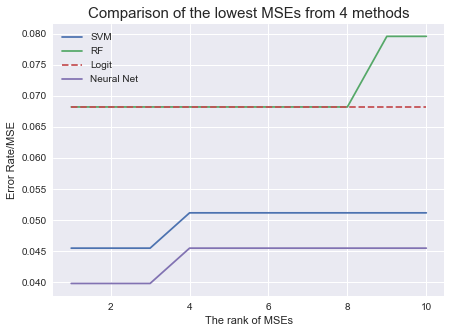

In [30]:
n = 10
best_logit = np.array(MSE_logit.sort_values(['MSE']).head(n)['MSE'])
best_RF = np.array(MSE_RF.sort_values(['MSE']).head(n)['MSE'])
best_SVM = np.array(MSE_SVM.sort_values(['MSE']).head(n)['MSE'])
best_mlp = np.array(MSE_mlp.sort_values(['MSE']).head(n)['MSE'])
rank = np.array(range(n)) + 1

Com = pd.DataFrame({'Logit':best_logit, 
                    'RF':best_RF,
                    'SVM':best_SVM,
                    'MLP':best_mlp,
                    'rank':rank})

plt.figure(figsize=(7,5))
plt.plot(Com['rank'], Com['SVM'], label='SVM')
plt.plot(Com['rank'], Com['RF'], label='RF')
plt.plot(Com['rank'], Com['Logit'], label='Logit', ls =  'dashed')
plt.plot(Com['rank'], Com['MLP'], label='Neural Net')
plt.legend(loc='best')
plt.title('Comparison of the lowest MSEs from 4 methods', fontsize = 15)
plt.xlabel('The rank of MSEs')
plt.ylabel("Error Rate/MSE")

So we can conclude that MLP is the best predictor of 'cultivar' since it has the lowest MSE.